<a href="https://colab.research.google.com/github/ephrem823/ML/blob/main/QA_amharic_nlp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [73]:
import json
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

##Data Loading

In [74]:
with open("/content/AmQA_Dataset.json", "r", encoding="utf-8") as f:
    data_loaded = json.load(f)

qas = []
for art in data_loaded['data']:
    paragraphs_raw = art["paragraphs"]
    if isinstance(paragraphs_raw, dict):
        paragraphs_list = [paragraphs_raw]
    elif isinstance(paragraphs_raw, list):
        paragraphs_list = paragraphs_raw
    else:
        continue

    for paragraph_data in paragraphs_list:
        context = paragraph_data["context"]
        for q in paragraph_data["qas"]:
            qas.append({
                "context": context,
                "question": q["question"],
                "answer": q["answers"][0]["text"]
            })
df_qas = pd.DataFrame(qas)

display(df_qas.head(2))

,context,question,answer
0,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ?,11
1,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,ከላሊበላ አስራ አንዱ ውቅር አብያተ ክርስቲያናት ግዙፉ የትኛው ነው?,ቤተ መድሃኔ ዓለም


##Data Cleaning and Preprocessing

In [75]:
def clean(t):
    t = re.sub(r"[A-Za-z!\"#$%&'()*+,-./:;<=>?@\[\]\\^_`{|}~]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_qas["cleaned_context"]  = df_qas["context"].apply(clean)
df_qas["cleaned_question"] = df_qas["question"].apply(clean)
df_qas["cleaned_answer"]   = df_qas["answer"].apply(clean)

display(df_qas[["cleaned_context", "cleaned_question", "cleaned_answer"]].head(2))

,cleaned_context,cleaned_question,cleaned_answer
0,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ,11
1,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,ከላሊበላ አስራ አንዱ ውቅር አብያተ ክርስቲያናት ግዙፉ የትኛው ነው,ቤተ መድሃኔ ዓለም


In [76]:
def normalize_script(text):
    return text

df_qas["normalized_context"] = df_qas["cleaned_context"].apply(normalize_script)

display(df_qas[["cleaned_context", "normalized_context"]].head(2))

,cleaned_context,normalized_context
0,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...
1,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...,ንጉሡ ላሊበላ የሚለውን ስም ያገኘው፣ ሲወለድ በንቦች ስለተከበበ ነው ይባ...


In [77]:
stop = set(["እና", "ወይም", "ነው", "ናት", "በ", "የ", "ለ", "እንደ", "እዚህ", "ይ", "ውስጥ",
    "ላይ", "ከ", "ጋር", "አንድ", "ሁለት", "ሶስት", "አራት", "አምስት", "ስድስት", "ሰባት",
    "ስምንት", "ዘጠኝ", "አስር", "እንዲሁም", "ነገር", "ግን", "ግን", "ምንም", "ማን", "ምን",
    "የት", "መቼ", "እንዴት", "ለምን", "እያለ", "ሲሆን", "ወደ", "ከዛ", "አሁን", "ብዙ",
    "ጥቂት", "ሁሉም", "እያንዳንዱ", "ማንኛውም", "ሌላ", "ሌሎች", "ራሱ", "ራሷ", "ራሳቸው",
    "ራሳችን", "ይህን", "ይህ", "ያ", "ያንን", "እነዚህ", "እነዚያ", "ሁለቱም", "በርካታ",
    "ብዙ", "በኋላ", "በፊት", "አዲስ", "የድሮ", "ትንሽ", "ትልቅ", "መካከል", "በላይ", "በታች",
    "አጭር", "ረዥም", "ፈጣን", "ቀስ", "ጥሩ", "መጥፎ", "በኋላ", "በቅርቡ", "ምንም", "የትም"])

def tokenizer(t): return [w for w in clean(t).split() if w not in stop]


df_qas["cleaned_context_tokens"] = df_qas["cleaned_context"].apply(tokenizer)
df_qas["cleaned_question_tokens"] = df_qas["cleaned_question"].apply(tokenizer)
df_qas["cleaned_answer_tokens"] = df_qas["cleaned_answer"].apply(tokenizer)

display(df_qas[["cleaned_context_tokens", "cleaned_question_tokens", "cleaned_answer_tokens"]].head(2))

,cleaned_context_tokens,cleaned_question_tokens,cleaned_answer_tokens
0,"[ንጉሡ, ላሊበላ, የሚለውን, ስም, ያገኘው፣, ሲወለድ, በንቦች, ስለተከ...","[በላሊበላ, ስንት, ውቅር, አብያተ, ክርስቲያናት, አሉ]",[11]
1,"[ንጉሡ, ላሊበላ, የሚለውን, ስም, ያገኘው፣, ሲወለድ, በንቦች, ስለተከ...","[ከላሊበላ, አስራ, አንዱ, ውቅር, አብያተ, ክርስቲያናት, ግዙፉ, የትኛው]","[ቤተ, መድሃኔ, ዓለም]"


##TF-IDF

In [88]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)

X_questions_tfidf = vectorizer.fit_transform(df_qas["cleaned_question"])
X_answers_tfidf = vectorizer.transform(df_qas["cleaned_answer"])

print("TF-IDF Matrix Shape for Questions:", X_questions_tfidf.shape)
print("TF-IDF Matrix Shape for Answers:", X_answers_tfidf.shape)
display(pd.DataFrame(X_questions_tfidf.toarray(), columns=vectorizer.get_feature_names_out()).head(2))

TF-IDF Matrix Shape for Questions: (2622, 6663)
TF-IDF Matrix Shape for Answers: (2622, 6663)


,000,1,10,100,102,10ኛ,10ኛውን,11,12,125ኛው,...,፳፯,፻,፻፳,፻፵፬,–,‘ኖርዝ,“ሎክሶዳንታ,“እቴሜቴ,“የኤንመርካርና,‹‹ብርሃን
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## cosin similarty

In [79]:
def predict_answer_with_cosine_similarity(question):
    cleaned_question = clean(question)
    tokenized_question = tokenizer(cleaned_question)
    processed_question = ' '.join(tokenized_question)

    if not processed_question.strip():
        return "No valid tokens found for the question.", 0.0

    question_tfidf = vectorizer.transform([processed_question])

    cosine_similarities = cosine_similarity(question_tfidf, X_answers_tfidf)

    most_similar_answer_index = cosine_similarities.argmax()
    max_cosine_similarity_score = cosine_similarities[0, most_similar_answer_index]

    predicted_answer_text = df_qas.loc[most_similar_answer_index, 'answer']

    return predicted_answer_text, max_cosine_similarity_score

print("The function 'predict_answer_with_cosine_similarity' has been defined.")

The function 'predict_answer_with_cosine_similarity' has been defined.


##Training and Testing Sets

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

split_shapes_df = pd.DataFrame({
    "Set": ["X_train", "X_test", "y_train", "y_test"],
    "Shape": [str(X_train.shape), str(X_test.shape), str(y_train.shape), str(y_test.shape)]
})
display(split_shapes_df)

,Set,Shape
0,X_train,"(2097, 6663)"
1,X_test,"(525, 6663)"
2,y_train,"(2097,)"
3,y_test,"(525,)"


##Train Naive Bayes Model

In [82]:
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression model trained successfully.


##model evaluation

In [86]:
y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.2f}")

report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
print("Classification Report (as DataFrame head):\n")

Model Accuracy on Test Set: 0.02
Classification Report (as DataFrame head):



In [87]:
display(report_df.head())

print("\nInterpretation of Results:")
print(f"As seen from the evaluation, the model's accuracy on the test set is {accuracy:.2f}.")
print("The classification report further indicates very low precision, recall, and f1-score across most classes.")
print(f"This poor performance is primarily due to the highly imbalanced nature of the dataset and the large number of unique answers. Even with {len(y_test)} samples in the test set, the model struggles to generalize effectively across so many distinct labels, leading to unreliable predictions.")

,precision,recall,f1-score,support
0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0



Interpretation of Results:
As seen from the evaluation, the model's accuracy on the test set is 0.02.
The classification report further indicates very low precision, recall, and f1-score across most classes.
This poor performance is primarily due to the highly imbalanced nature of the dataset and the large number of unique answers. Even with 525 samples in the test set, the model struggles to generalize effectively across so many distinct labels, leading to unreliable predictions.


##Visualize

###Training Set

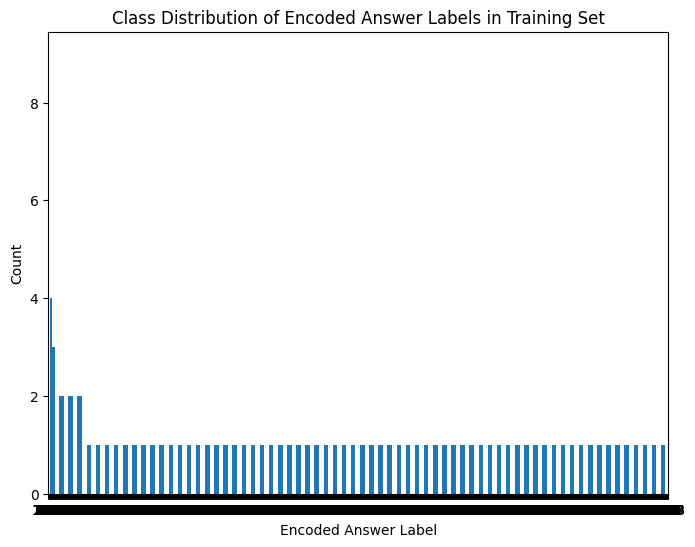

In [89]:
class_counts_train = y_train.value_counts()

plt.figure(figsize=(8, 6))
class_counts_train.plot(kind='bar')
plt.title('Class Distribution of Encoded Answer Labels in Training Set')
plt.xlabel('Encoded Answer Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### test set

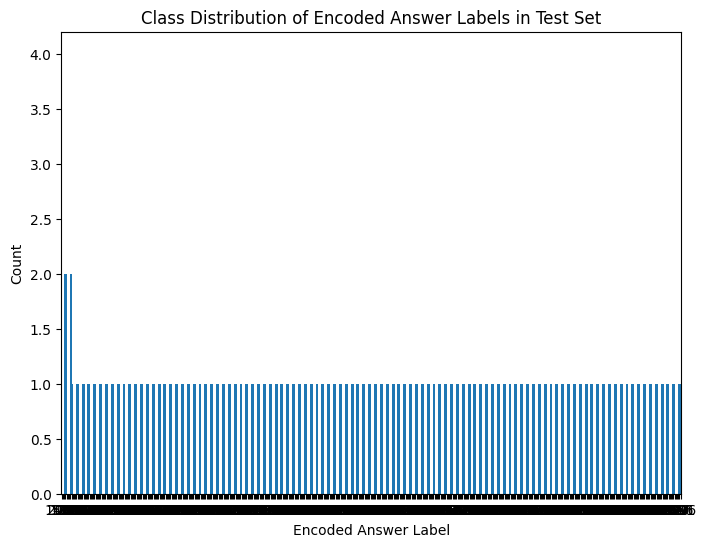

In [90]:
class_counts_test = y_test.value_counts()

plt.figure(figsize=(8, 6))
class_counts_test.plot(kind='bar')
plt.title('Class Distribution of Encoded Answer Labels in Test Set')
plt.xlabel('Encoded Answer Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

##Prediction for a New Question

In [91]:
new_question = input("እባክዎ አዲስ ጥያቄ ያስገቡ (Please enter a new question): ")

print(f"You entered: {new_question}")

cleaned_new_question = clean(new_question)
tokenized_new_question = tokenizer(cleaned_new_question)
processed_new_question = ' '.join(tokenized_new_question)

print("\n--- Processed Question Details ---")
processed_question_df = pd.DataFrame({
    "Step": ["Cleaned Question", "Tokenized Question", "Processed Question for Vectorizer"],
    "Result": [cleaned_new_question, str(tokenized_new_question), processed_new_question]
})
display(processed_question_df)

new_question_tfidf = vectorizer.transform([processed_new_question])

print("\n--- TF-IDF Vector Shape ---")
tfidf_shape_df = pd.DataFrame({
    "Description": ["TF-IDF Vector Shape for New Question"],
    "Shape": [str(new_question_tfidf.shape)]
})
display(tfidf_shape_df)


cosine_similarities = cosine_similarity(new_question_tfidf, X_answers_tfidf)

most_similar_answer_index = cosine_similarities.argmax()
max_cosine_similarity_score = cosine_similarities[0, most_similar_answer_index]

predicted_answer_text = df_qas.loc[most_similar_answer_index, 'answer']

print("\n--- Predicted Answer Details (Cosine Similarity) ---")
prediction_details_df = pd.DataFrame({
    "Description": ["Predicted Answer", "Cosine Similarity Score"],
    "Value": [predicted_answer_text, f"{max_cosine_similarity_score:.4f}"]
})
display(prediction_details_df)


እባክዎ አዲስ ጥያቄ ያስገቡ (Please enter a new question): በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ
You entered: በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ

--- Processed Question Details ---


,Step,Result
0,Cleaned Question,በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ
1,Tokenized Question,"['በላሊበላ', 'ስንት', 'ውቅር', 'አብያተ', 'ክርስቲያናት', 'አሉ']"
2,Processed Question for Vectorizer,በላሊበላ ስንት ውቅር አብያተ ክርስቲያናት አሉ



--- TF-IDF Vector Shape ---


,Description,Shape
0,TF-IDF Vector Shape for New Question,"(1, 6663)"



--- Predicted Answer Details (Cosine Similarity) ---


,Description,Value
0,Predicted Answer,በ13ኛው መቶ ክፍለዘመን የተሰሩ 11 አብያተ-ክርስቲያናት
1,Cosine Similarity Score,0.3871
